### Import Model Architectures
Custom Torch Models need to be instantiated for evaluation. The model_architectures.py file contains the model architectures so we can abstract it and focus only on the evaluations.

In [1]:
from model_architectures import *
import torchvision
import model_architectures
from attacks import * 
# Print available classes to verify our model architectures were imported
print(dir(model_architectures))

Using device: cuda


C:\Users\Sai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
['BasicBlock', 'DataLoader', 'F', 'Load', 'ResNetCIFAR', 'ResNetMNIST', 'ResnetSVHN', 'TensorDataset', 'Tester', 'Visualizer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'cifar_directory', 'conv3x3', 'current_directory', 'device', 'mnist_directory', 'nn', 'np', 'os', 'pd', 'pickle', 'plt', 'scipy', 'svhn_directory', 'torch']


### Loading the Model Weights
Using our model artifacts we load the weights back into the model so we have our pre-trained models to test our perturbations against.

In [2]:
mnist_resnet_model = ResNetMNIST(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=True).to(device)
cifar_resnet_model = ResNetCIFAR(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)
svhn_resnet_model = ResnetSVHN(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)

#add map_location=torch.device('cpu') if running locally and ur not sai lol
device = 'cuda'
# mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth", map_location=torch.device(device)))
# cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth", map_location=torch.device(device)))
# svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth",map_location=torch.device(device)))
mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth"))
cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth"))
svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth"))


# attack = "fully"
# mnist_resnet_model.load_state_dict(torch.load(f"artifacts/{attack}_augmented_resnet18_mnist_model.pth"))
# cifar_resnet_model.load_state_dict(torch.load(f"artifacts/{attack}_augmented_resnet18_cifar_model.pth"))
# svhn_resnet_model.load_state_dict(torch.load(f"artifacts/{attack}_augmented_resnet18_svhn_model.pth"))

<All keys matched successfully>

In [3]:
# Set models to evaluation mode
mnist_resnet_model.eval()
cifar_resnet_model.eval()
svhn_resnet_model.eval()

ResnetSVHN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [4]:
loader = Load()
mnist_test_images, mnist_test_labels = loader.load_mnist_test_images()
cifar10_test_images, cifar10_test_labels = loader.load_cifar10_test_images()
svhn_test_images, svhn_test_labels = loader.load_svhn_test_images()

In [5]:
test_loader_mnist = loader.convert_mnist_numpy_to_tensor(mnist_test_images[:256], mnist_test_labels[:256])
test_loader_cifar10 = loader.convert_cifar10_numpy_to_tensor(cifar10_test_images[:256], cifar10_test_labels[:256])
test_loader_svhn = loader.convert_svhn_numpy_to_tensor(svhn_test_images[:256], svhn_test_labels[:256])
tester = Tester()

In [6]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

# Jacobian Saliency Map Attack

The jacobian saliency map attack is a white box attack that takes in the inputs: target class; theta, the change made to pixels within the image; and upsilon, the maximum distortion allowed to the image. JSMA operates relatively intuitively; it is an iterative attack that utilizes the "saliency map" of an image (in computer vision, the saliency map of an image is the concentration of pixels on which people's eyes focus on first) to distort the image enough so that it is interpreted as the target class by the model

In [7]:
print("Attack Image & Predicted Label")
viz = Visualizer()


def test_jsma(model, test_loader, theta = 0.1):
    model.eval()

    pred_list = []
    correct = 0
    total = 0
    adv_examples = []

    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        for image, label in zip(images, labels):
            image = image.unsqueeze(0)
            label = label.unsqueeze(0)

            output, _ = model(image)

            # print(outputs)

            _, init_pred = torch.max(output.data, 1)
            
            if not torch.equal(init_pred, label):
                total +=1 
                continue 
            
            target = torch.topk(output,2).indices[0][1].item()
            advimages = jsma_attack(model, image, target, 10, theta = theta)
            output_adv, _ = model(advimages)
            
            _, prediction_adv = torch.max(output_adv.data, 1)

            if torch.equal(prediction_adv, label):
                correct += 1
            else:
                adv_ex = advimages.squeeze().detach().cpu().numpy()

                adv_examples.append( (init_pred.item(), prediction_adv.item(), adv_ex) )
                pred_list.append(prediction_adv)
                    
                        
            total +=1 
            print(correct, "/", total)  
            # if (total>0):
            #     break
            
    print('Accuracy of test text: %f %%' % ((float(correct) / total) * 100))
    return adv_examples


Attack Image & Predicted Label


In [8]:
adv_examples = test_jsma(mnist_resnet_model, test_loader_mnist, theta = 0.025)

0 / 1
0 / 2
0 / 3
0 / 4
0 / 5
0 / 6
0 / 7
0 / 8
0 / 9
0 / 10
0 / 11
0 / 12
0 / 13
0 / 14
0 / 15
0 / 16
0 / 17
0 / 18
0 / 19
0 / 20
0 / 21
0 / 22
0 / 23
0 / 24
0 / 25
0 / 26
0 / 27
0 / 28
0 / 29
0 / 30
0 / 31
0 / 32
0 / 33
0 / 34
0 / 35
0 / 36
0 / 37
0 / 38
0 / 39
0 / 40
0 / 41
0 / 42
0 / 43
0 / 44
0 / 45
0 / 46
0 / 47
0 / 48
1 / 49
1 / 50
1 / 51
1 / 52
1 / 53
1 / 54
1 / 55
1 / 56
1 / 57
1 / 58
1 / 59
1 / 60
1 / 61
1 / 62
1 / 63
1 / 64
1 / 65
1 / 66
1 / 67
1 / 68
1 / 69
1 / 70
1 / 71
1 / 72
1 / 73
1 / 74
1 / 75
1 / 76
1 / 77
1 / 78
1 / 79
1 / 80
1 / 81
1 / 82
1 / 83
1 / 84
1 / 85
1 / 86
1 / 87
1 / 88
1 / 89
1 / 90
1 / 91
1 / 92
1 / 93
1 / 94
1 / 95
1 / 96
1 / 97
1 / 98
1 / 99
1 / 100
1 / 101
1 / 102
1 / 103
1 / 104
1 / 105
1 / 106
1 / 107
1 / 108
1 / 109
1 / 110
1 / 111
1 / 112
1 / 113
1 / 114
1 / 115
1 / 116
1 / 117
1 / 118
1 / 119
1 / 120
1 / 121
1 / 122
1 / 123
1 / 124
1 / 125
1 / 126
1 / 127
1 / 128
1 / 129
1 / 130
1 / 131
1 / 132
1 / 133
1 / 134
1 / 135
1 / 136
1 / 137
1 / 138
1 / 

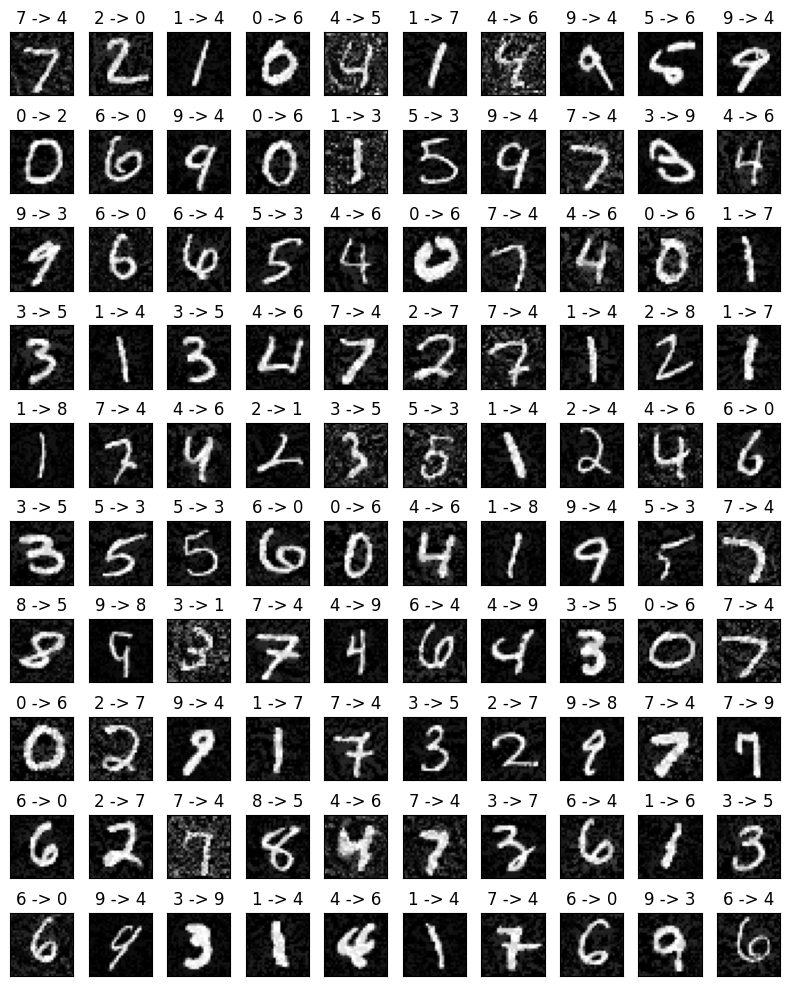

In [9]:
# num_cols = len(adv_examples)
# print(num_cols)

plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    plt.title(f"{orig} -> {adv}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [10]:
adv_examples = test_jsma(cifar_resnet_model, test_loader_cifar10, theta = 0.000625)

0 / 1
0 / 2
0 / 4
0 / 6
0 / 7
0 / 8
0 / 10
0 / 11
0 / 12
0 / 14
0 / 15
0 / 16
0 / 17
0 / 18
0 / 19
0 / 20
0 / 22
0 / 24
0 / 26
0 / 27
0 / 28
0 / 29
0 / 30
0 / 31
0 / 33
0 / 34
0 / 35
0 / 38
0 / 39
0 / 40
0 / 41
0 / 42
0 / 44
0 / 45
0 / 46
0 / 47
0 / 49
0 / 50
0 / 51
0 / 52
0 / 54
0 / 55
0 / 56
0 / 57
0 / 61
0 / 63
0 / 64
0 / 65
0 / 66
0 / 67
0 / 68
0 / 71
0 / 72
0 / 73
0 / 74
0 / 75
0 / 76
0 / 78
0 / 79
0 / 80
0 / 81
0 / 83
0 / 84
0 / 85
0 / 87
0 / 89
0 / 90
0 / 91
0 / 93
0 / 94
0 / 95
0 / 96
0 / 97
0 / 98
0 / 99
0 / 100
0 / 101
0 / 102
0 / 103
0 / 105
0 / 106
0 / 108
0 / 109
0 / 110
0 / 111
0 / 112
0 / 114
0 / 116
0 / 117
0 / 118
0 / 121
0 / 122
0 / 123
0 / 124
0 / 125
0 / 127
0 / 128
0 / 131
0 / 132
0 / 133
0 / 134
0 / 135
0 / 136
0 / 137
0 / 138
0 / 139
0 / 141
0 / 142
0 / 143
0 / 144
0 / 145
0 / 146
0 / 147
0 / 150
0 / 151
0 / 152
0 / 153
0 / 154
0 / 155
0 / 156
0 / 157
0 / 158
0 / 160
0 / 162
0 / 163
0 / 164
0 / 166
0 / 167
0 / 168
0 / 171
0 / 172
0 / 174
0 / 175
0 / 176
0 / 177
0

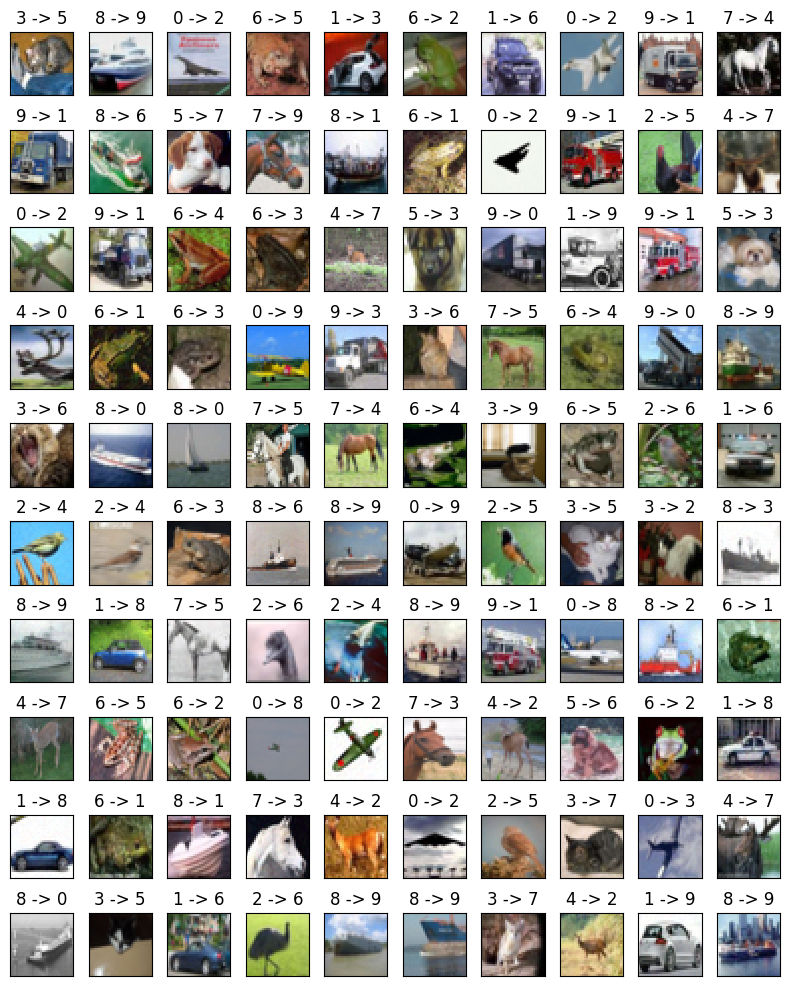

In [11]:
label_mapping = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    # ex = ex / 255 # Normalizing pixel values
    plt.title(f"{orig} -> {adv}")
    plt.imshow(ex)
plt.tight_layout()
plt.show()

In [12]:
adv_examples = test_jsma(svhn_resnet_model, test_loader_svhn, theta = 0.0025)

0 / 1
0 / 2
0 / 3
0 / 4
0 / 5
0 / 6
0 / 7
0 / 8
0 / 9
0 / 10
0 / 11
0 / 12
0 / 13
0 / 14
0 / 15
0 / 16
0 / 17
0 / 18
0 / 19
0 / 20
0 / 21
0 / 22
0 / 23
0 / 25
0 / 26
0 / 27
0 / 28
0 / 29
0 / 30
0 / 32
0 / 33
0 / 34
0 / 35
0 / 36
0 / 37
0 / 38
0 / 39
0 / 40
0 / 42
0 / 43
0 / 44
0 / 45
0 / 46
0 / 47
0 / 48
0 / 49
0 / 50
0 / 51
0 / 52
0 / 53
0 / 54
0 / 55
0 / 58
0 / 61
0 / 62
0 / 63
0 / 64
0 / 65
0 / 66
0 / 67
0 / 68
0 / 69
0 / 70
0 / 71
0 / 72
0 / 73
0 / 74
0 / 75
0 / 76
0 / 77
0 / 78
0 / 79
0 / 80
0 / 81
0 / 82
0 / 83
0 / 84
0 / 85
0 / 86
0 / 87
0 / 88
0 / 89
0 / 90
0 / 91
0 / 92
0 / 93
0 / 94
0 / 95
0 / 96
0 / 98
0 / 99
0 / 100
0 / 101
0 / 102
0 / 103
0 / 104
0 / 105
0 / 106
0 / 107
0 / 108
0 / 109
0 / 110
0 / 111
0 / 112
0 / 113
0 / 115
0 / 116
0 / 117
0 / 118
0 / 119
0 / 120
0 / 121
0 / 122
0 / 123
0 / 124
0 / 125
0 / 126
0 / 127
0 / 128
0 / 129
0 / 130
0 / 131
0 / 133
0 / 134
0 / 135
0 / 136
0 / 137
0 / 138
0 / 139
0 / 140
0 / 142
0 / 143
0 / 144
0 / 145
0 / 146
0 / 147
0 / 148
0 / 

[[[0.15401961 0.15794118 0.15794118 ... 0.15578432 0.15970589 0.15794118]
  [0.15794118 0.15294118 0.15794118 ... 0.15578432 0.16362746 0.15794118]
  [0.14401962 0.14009805 0.14794119 ... 0.16362746 0.16362746 0.15294118]
  ...
  [0.20392157 0.21284313 0.19500001 ... 0.17254902 0.16754903 0.15578432]
  [0.19107844 0.19500001 0.18715687 ... 0.16754903 0.1714706  0.16470589]
  [0.1932353  0.1832353  0.17539217 ... 0.16862746 0.16754903 0.15970589]]

 [[0.39892158 0.40784314 0.41284314 ... 0.395      0.39892158 0.37539217]
  [0.41284314 0.41284314 0.41284314 ... 0.395      0.39107844 0.38539216]
  [0.40676472 0.40284315 0.41068628 ... 0.39107844 0.38715687 0.37539217]
  ...
  [0.47166666 0.46558824 0.4577451  ... 0.4577451  0.45382354 0.44205883]
  [0.45882353 0.4577451  0.44990197 ... 0.45382354 0.44990197 0.43813726]
  [0.4559804  0.4459804  0.43813726 ... 0.44990197 0.4459804  0.43813726]]

 [[0.24029411 0.24421568 0.24813725 ... 0.23421569 0.24813725 0.22852941]
  [0.24421568 0.239215

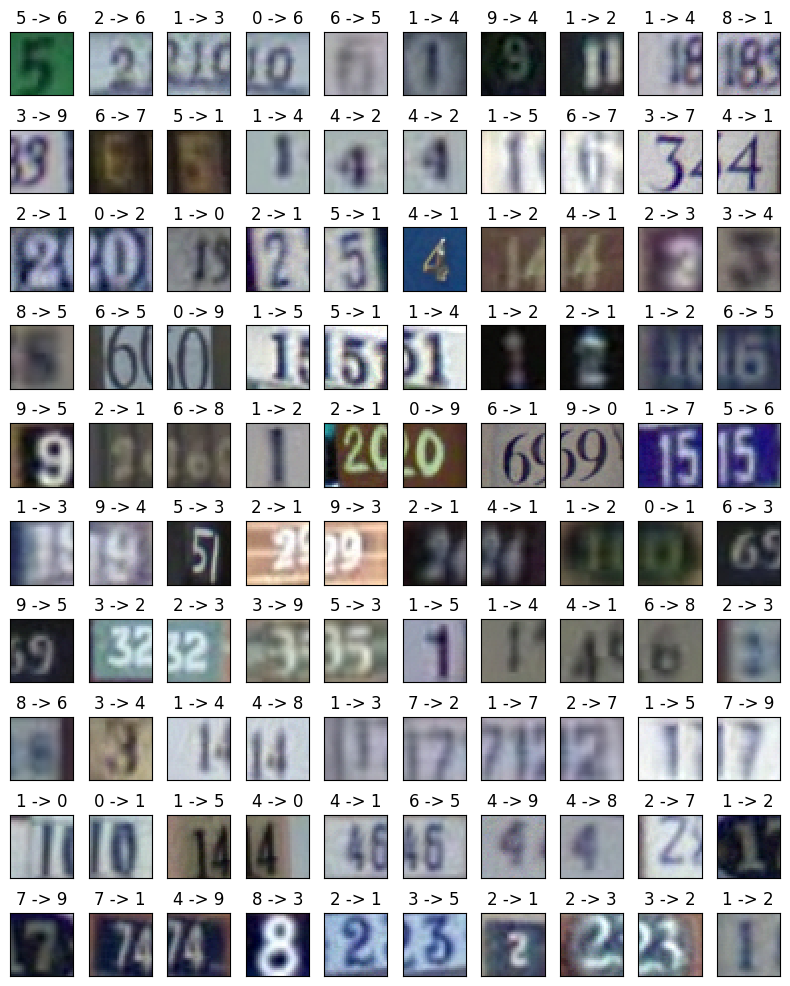

In [13]:
# Test visualizer with an image available in test data
viz = Visualizer()
label_mapping2 = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9'
}

print(adv_examples[0][2])

plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    # ex = ex / 255 # Normalizing pixel values
    plt.title(f"{orig} -> {adv}")
    plt.imshow(ex)
plt.tight_layout()
plt.show()